# Investigating the role of pre-miRNA concentration on competition

Using same model as for the investigations into the competition effects between 8 theoretical pre-miRNAs

## Set up workspace

In [64]:
import model_utils as mu
import params
from scipy.integrate import solve_ivp
from scipy.integrate import simpson
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm
import seaborn as sns
import matplotlib.style as style
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
style.use('seaborn-colorblind')

In [2]:
destdir_csvs = './outputs/premir-conc-vars/csvs/'
destdir_figs = './outputs/premir-conc-vars/plots/'

## Generate model

In [3]:
#make 2 miRNA model
ODE_inits = [0]*8*4 + [0]
ODE_ka = [0] * 8
ODE_kb = ODE_ka
ODE_kc = ODE_ka
ODE_kd = ODE_ka

In [4]:
ode = mu.makeODEs(ODE_inits, ODE_ka, ODE_kb, ODE_kc, ODE_kd)

In [5]:
model = mu.makeModel(ode)

## Set up conditions for models

In [6]:
high = 10
low = 1
k = 2

In [7]:
inits1 = [params.init_pMiR1, params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, params.init_MiR1] * 8

In [8]:
ka = [params.ka1 * high, params.ka1 * low] + [params.ka1] * 2 +\
     [params.ka1 * high * k, params.ka1 * low] + [params.ka1 * k] * 2

kb = [params.ka1 * params.Kd_wt, params.ka1 * params.Kd_wt * high]  + \
    [params.ka1 * params.Kd_wt] * 2 + \
    [params.ka1 * params.Kd_wt, params.ka1 * params.Kd_wt * high * k] +\
    [params.ka1 * params.Kd_wt] * 2

kc = [params.kc1] * 2 + [params.kc1 * high, params.kc1] + \
     [params.kc1] * 2 + [params.kc1 * high * k, params.kc1]

kd = [params.kd] * 3 + [params.kd * high] + [params.kd] * 3 + [params.kd * high * k]

In [9]:
#Dicer concentration variations
dvars = np.linspace(0, 7.25, 15)
dvars[0] = 0.01
dvars = np.append(dvars, np.linspace(10, 15, 4))
variations = [str(int(i * 100)) for i in list(dvars)]

In [10]:
#pre-miRNA concentration variations
pvars = np.linspace(0, 1, 5)
pvars = np.append(pvars, np.linspace(1.5, 5, 8))
p_variations = [str(int(i*100)) for i in list(dvars)]

## Run model, save outputs

In [11]:
exec(model)

In [12]:
names = []
for ii in tqdm(range(len(dvars))):
    for ij in range(0, int(8*4), 4):
        for ik in range(len(pvars)):
            name = 'model_d' + variations[ii] + '_miR' + str(int(ij/4)) + '_' + p_variations[ik]
            
            init = inits1 + [dvars[ii]]
            init[ij] = init[ij] * pvars[ik]
            
            res = solve_ivp(runModel, (0, int(params.minutes)), init, \
                            args = (ka, kb, kc, kd), method = 'LSODA')
    
            mirna_length = int((len(res.y)-1)/4)
            index = []
    
            for j in range(mirna_length):
                index = index + ['pMiR' + str(j), 'pMiR_dicer' + str(j), \
                                 'pMiR_dicer_star' + str(j), 'miR' + str(j)]
    
            index = index + ['dicer']
    
            df = pd.DataFrame(res.y, index = index)
            df = df.transpose()
            df.insert(loc = 0, column = 'time_min', value = res.t)
    
            names.append(name)
    
            df.to_csv(destdir_csvs + name + '.csv', index = False)

df1 = pd.DataFrame({'names': names})
df1.to_csv(destdir_csvs + 'names.csv', index = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:58<00:00,  3.05s/it]


## Plotting

In [11]:
#load data (only if restarting notebook)
names = pd.read_csv(destdir_csvs + 'names.csv')
names = list(names['names'])

In [12]:
#prep data for plotting
##read data
for name in tqdm(names):
    exec(name + ' = pd.read_csv("' + destdir_csvs + name + '.csv", header = [0])')

100%|██████████| 1976/1976 [00:05<00:00, 333.76it/s]


In [13]:
#prep end points for plotting
##[pMiR that's varied][pMiR concentrations][Dicer concentrations]
ends = {'miR0_changed': np.zeros((8, len(pvars), len(dvars))), 'miR1_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR2_changed': np.zeros((8, len(pvars), len(dvars))), 'miR3_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR4_changed': np.zeros((8, len(pvars), len(dvars))), 'miR5_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR6_changed': np.zeros((8, len(pvars), len(dvars))), 'miR7_changed': np.zeros((8, len(pvars), len(dvars)))}


for k in tqdm(range(8)):
    for j in range(len(pvars)):
        for i in range(len(dvars)):
            exec('miR = model_d' + variations[i] + '_miR' + str(k) + '_' + p_variations[j])
            ends['miR' + str(k) + '_changed'][0][j][i] = miR['miR0'].iloc[-1]
            ends['miR' + str(k) + '_changed'][1][j][i] = miR['miR1'].iloc[-1]
            ends['miR' + str(k) + '_changed'][2][j][i] = miR['miR2'].iloc[-1]
            ends['miR' + str(k) + '_changed'][3][j][i] = miR['miR3'].iloc[-1]
            ends['miR' + str(k) + '_changed'][4][j][i] = miR['miR4'].iloc[-1]
            ends['miR' + str(k) + '_changed'][5][j][i] = miR['miR5'].iloc[-1]
            ends['miR' + str(k) + '_changed'][6][j][i] = miR['miR6'].iloc[-1]
            ends['miR' + str(k) + '_changed'][7][j][i] = miR['miR7'].iloc[-1]

100%|██████████| 8/8 [00:00<00:00, 11.51it/s]


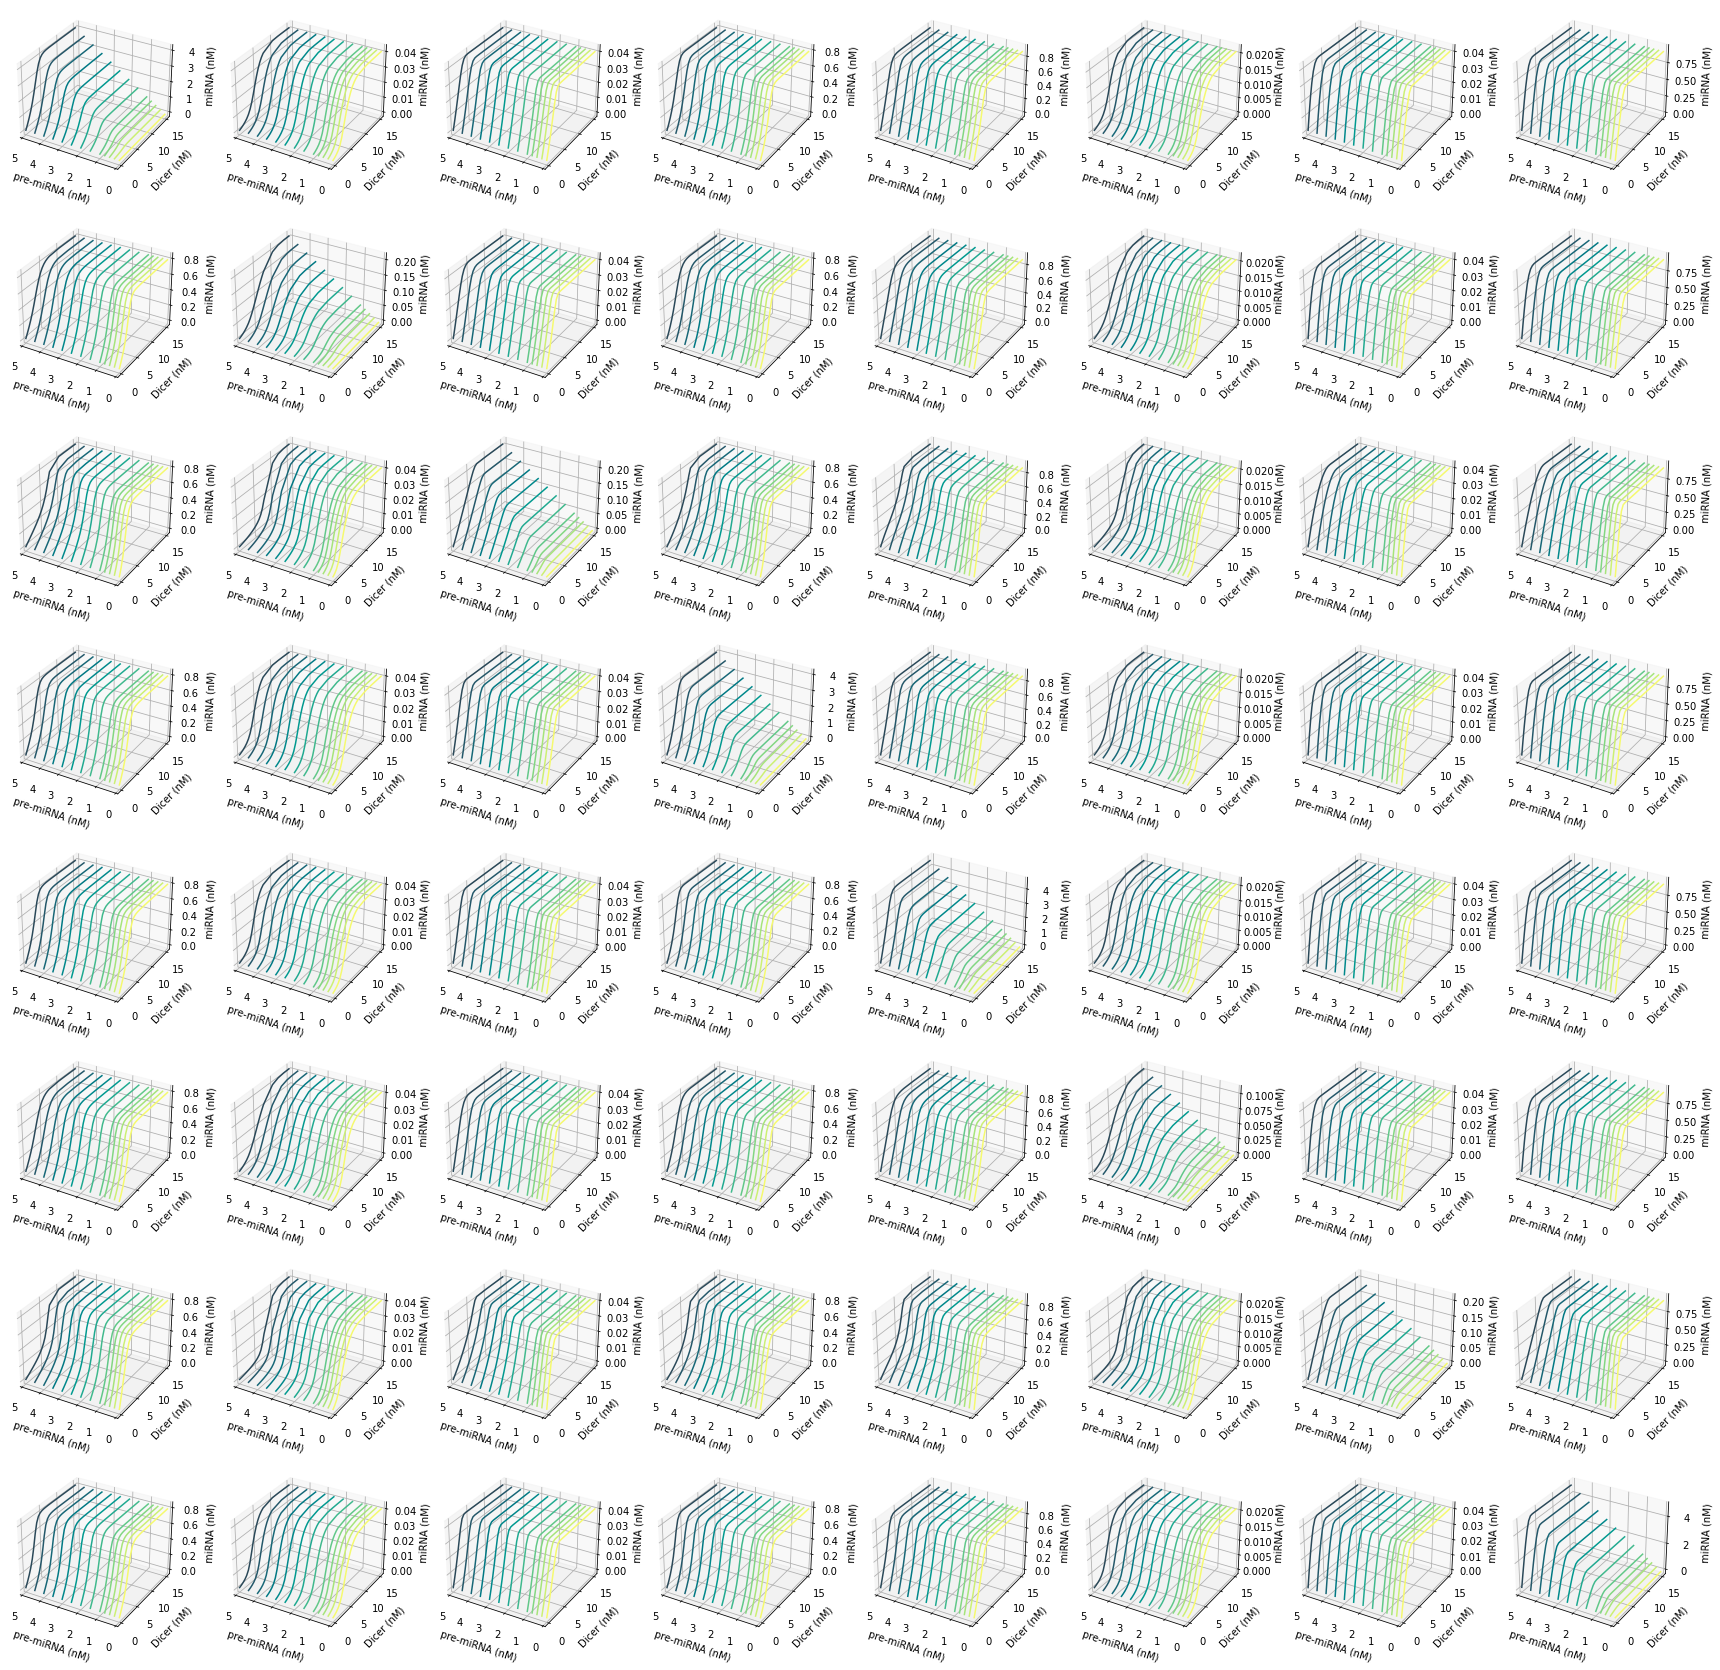

In [14]:
#plot 3d plots
fig = plt.figure(figsize = (30,30))

color_gradient = ["#f5fa6e", "#ccf073", "#a6e47a", "#82d781", "#61c888", "#40b98d", "#1fa990",
                  "#00998f", "#00888b", "#007883", "#176777", "#245769", "#2a4858"]

plot_ixs = np.arange(8*8).reshape((8,8))
plot_ixs = plot_ixs + np.ones((8,8))

for i in range(8):
    for j in range(8):
        exec('ax' + ' = fig.add_subplot(8, 8, ' + str(int(plot_ixs[i][j])) + ', projection = "3d")')
        
        for k in range(len(pvars)):
            ax.plot(dvars,
                    ends['miR' + str(i) + '_changed'][j][k],
                    pvars[k],
                    color = color_gradient[k])
            ax.set_xlabel('Dicer (nM)')
            ax.set_ylabel('miRNA (nM)')
            ax.set_zlabel('pre-miRNA (nM)')
            ax.invert_zaxis()
            ax.view_init(vertical_axis = 'y')

#along x-axis: affected miRNA
#along y-axis: changed pre-miRNA

plt.savefig(destdir_figs + 'all_mirnas_matrix.svg', dpi = 600, bbox_inches = 'tight')

plt.show()
                

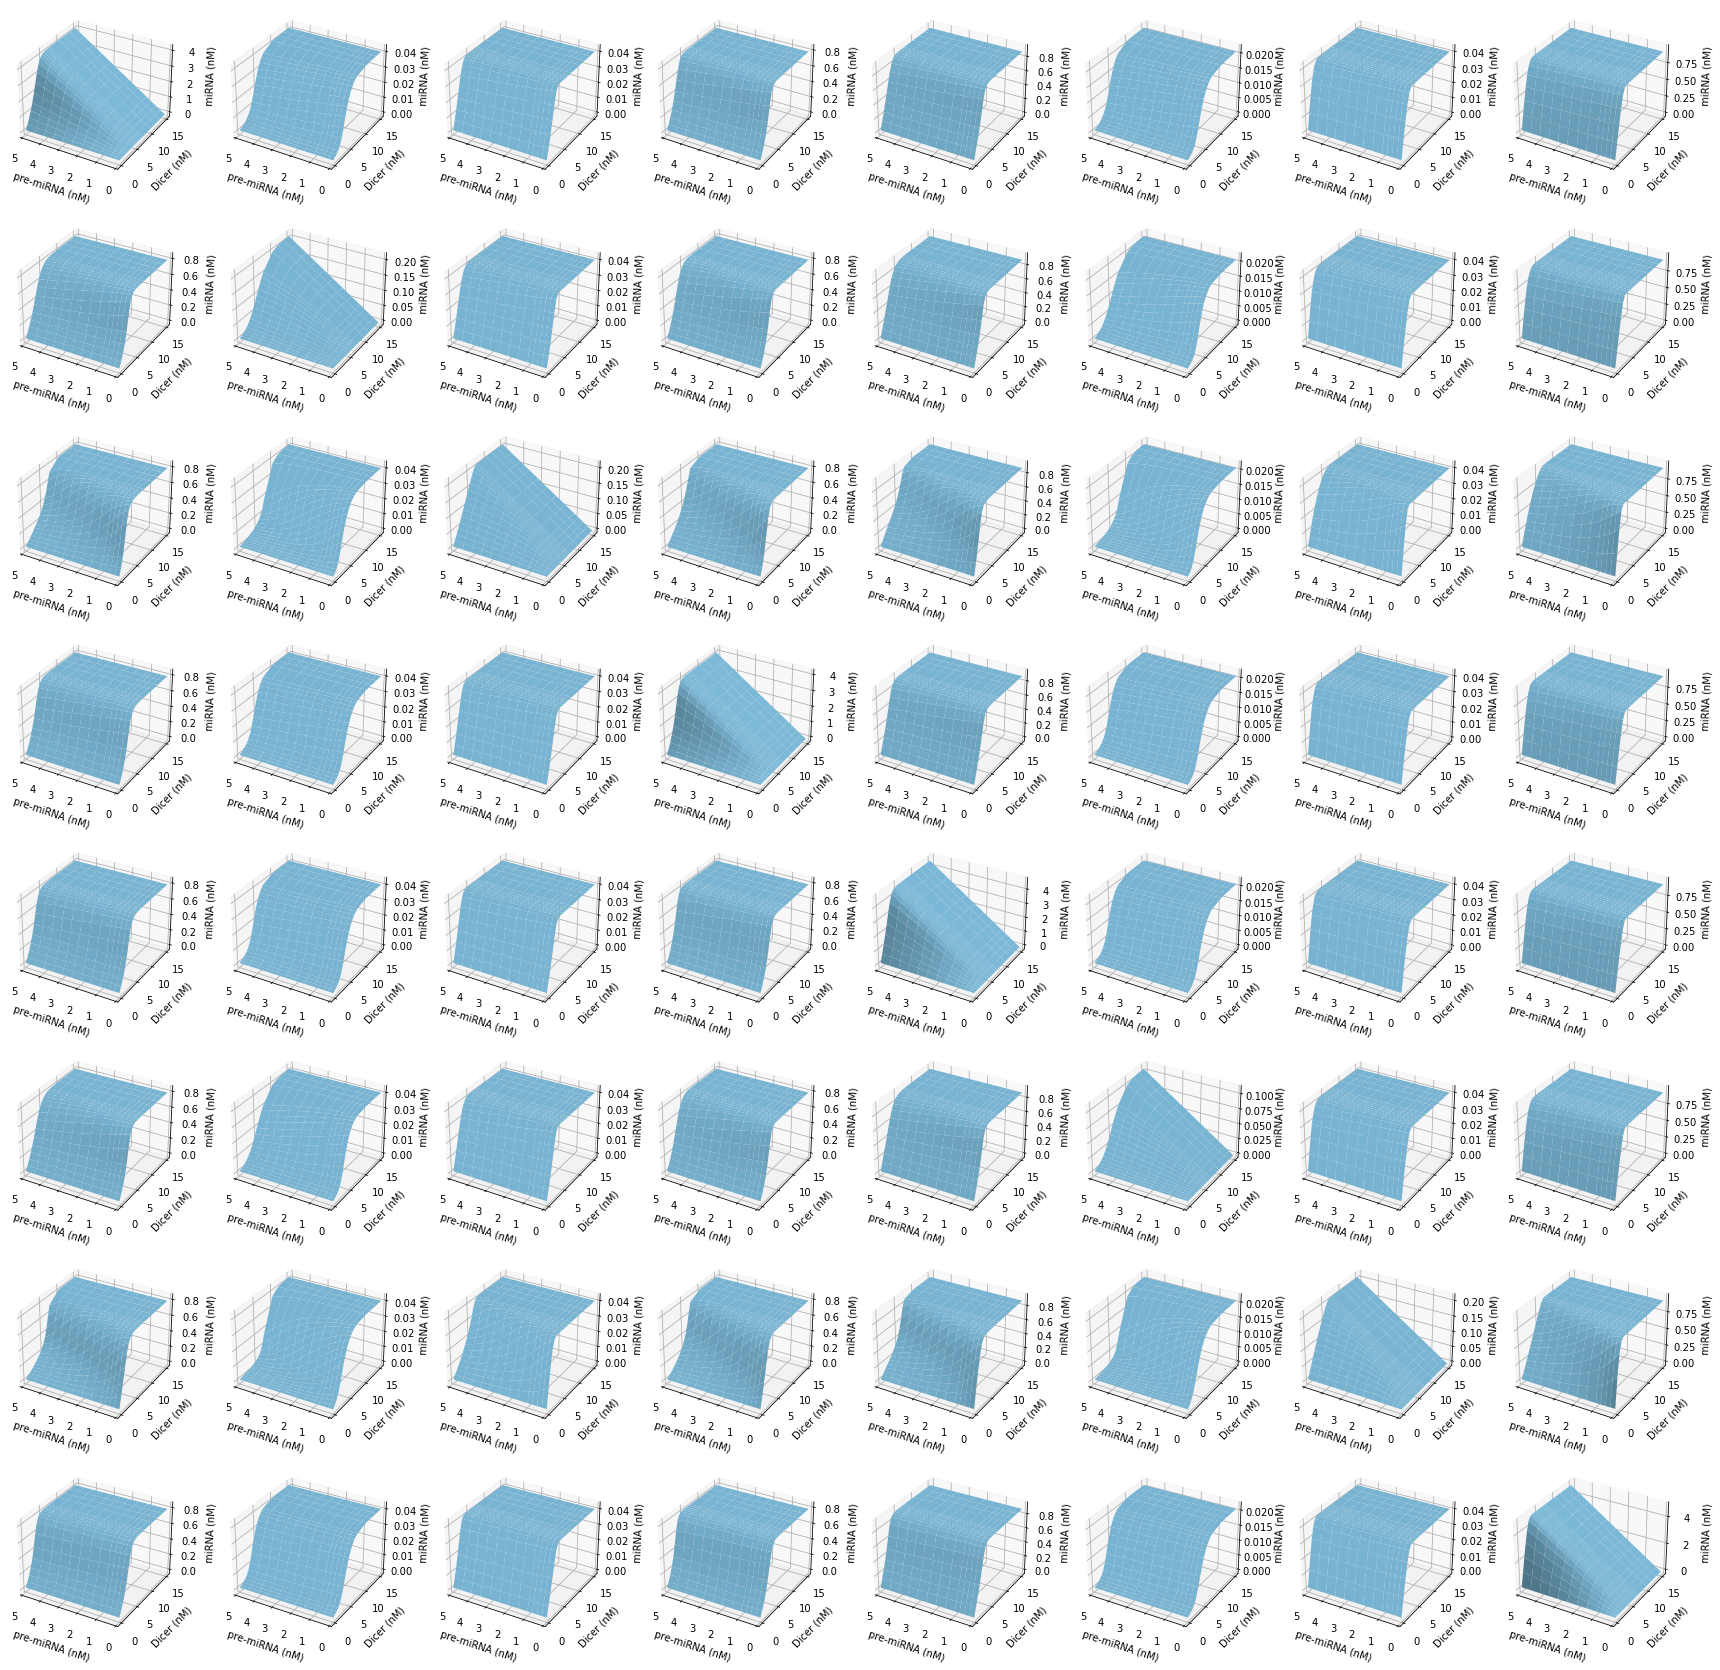

In [15]:
#plot 3d plots
fig = plt.figure(figsize = (30,30))
plot_ixs = np.arange(8*8).reshape((8,8))
plot_ixs = plot_ixs + np.ones((8,8))

for i in range(8):
    for j in range(8):
        exec('ax' + ' = fig.add_subplot(8, 8, ' + str(int(plot_ixs[i][j])) + ', projection = "3d")')
        
        x = dvars
        z = pvars
        x, z = np.meshgrid(x, z)
        y = ends['miR' + str(i) + '_changed'][j]
        ax.plot_surface(x,
                y,
                z,
                color = params.colors[0][1])
        ax.set_xlabel('Dicer (nM)')
        ax.set_ylabel('miRNA (nM)')
        ax.set_zlabel('pre-miRNA (nM)')
        ax.invert_zaxis()
        ax.view_init(vertical_axis = 'y')

#along x-axis: affected miRNA
#along y-axis: changed pre-miRNA

plt.savefig(destdir_figs + 'all_mirnas_matrix-surface.svg', dpi = 600, bbox_inches = 'tight')

plt.show()
                

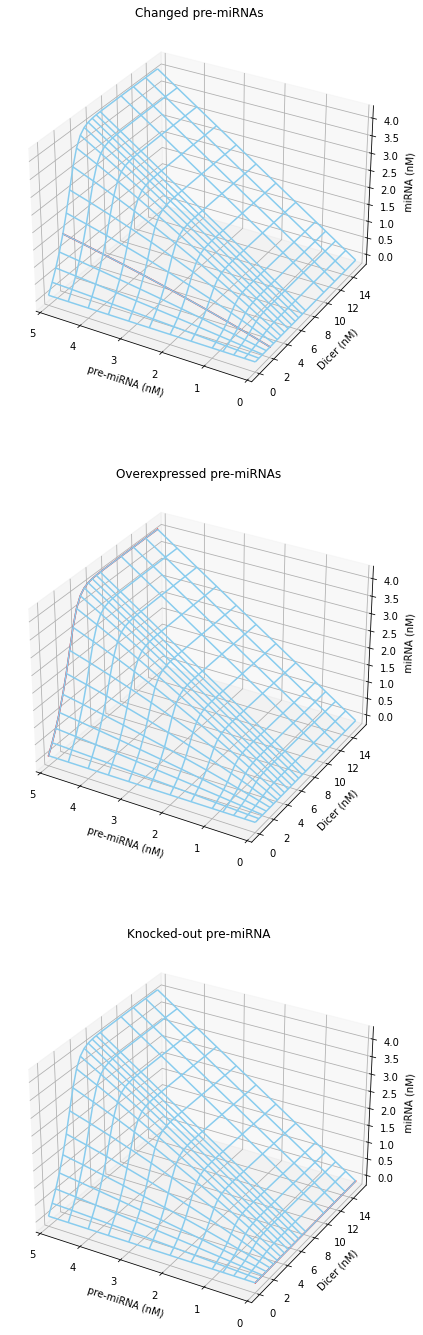

In [16]:
#plot example figures
fig = plt.figure(figsize = (8, int(8*3)))

x = dvars
z = pvars
X, Z = np.meshgrid(x, z)
y = ends['miR0_changed'][0]

#changed pre-miRNA concentration at ~2nM Dicer
ax1 = fig.add_subplot(3,1,1, projection = '3d')
ax1.plot_wireframe(X,
                y,
                Z,
                color = params.colors[0][1])
ax1.set_xlabel('Dicer (nM)')
ax1.set_ylabel('miRNA (nM)')
ax1.set_zlabel('pre-miRNA (nM)')
ax1.invert_zaxis()
ax1.view_init(vertical_axis = 'y')


ax1.plot([dvars[4]] * len(y[:, 4]),
         y[:, 4],
         pvars,
         color = 'red')

ax1.set_title('Changed pre-miRNAs')

#overexpressed pre-miRNA
ax2 = fig.add_subplot(3,1,2, projection = '3d')
ax2.plot_wireframe(X,
                y,
                Z,
                color = params.colors[0][1])
ax2.set_xlabel('Dicer (nM)')
ax2.set_ylabel('miRNA (nM)')
ax2.set_zlabel('pre-miRNA (nM)')
ax2.invert_zaxis()
ax2.view_init(vertical_axis = 'y')

ax2.plot(dvars,
         y[-1, :],
         [pvars[-1]]*len(dvars),
         color = 'red')
ax2.set_title('Overexpressed pre-miRNAs')

#knocked out pre-miRNA
ax3 = fig.add_subplot(3,1,3, projection = '3d')
ax3.plot_wireframe(X,
                y,
                Z,
                color = params.colors[0][1])
ax3.set_xlabel('Dicer (nM)')
ax3.set_ylabel('miRNA (nM)')
ax3.set_zlabel('pre-miRNA (nM)')
ax3.invert_zaxis()
ax3.view_init(vertical_axis = 'y')

ax3.plot(dvars,
         y[0, :],
         [pvars[0]]*len(dvars),
         color = 'red')
ax3.set_title('Knocked-out pre-miRNA')

plt.savefig(destdir_figs + 'example_figures.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [17]:
#subset data to plot following:
##effect of pre-miRNA concentration on competition when [Dicer] ~ 2 (dvars[4])
##effect of Dicer on sequentially knocked out pre-miRNAs ([pre-miRNA] = 0 (pvars[0])
##effect of Dicer on sequentially over-expressed pre-miRNAs ([pre-miRNA] = 5. (pvars[-1])
pmir_var = {}
pmir_ko = {}
pmir_oe = {}

for i in tqdm(range(8)):
    for j in range(8):
        exec('data = ends["miR' + str(i) + '_changed"][' + str(j) + ']')
        
        if j == 0:
            pmir_var["miR" + str(i) + "_changed"] = np.array([data[:,4]])
            pmir_ko["miR" + str(i) + "_changed"] = np.array([data[np.where(pvars == 0)[0][0]]])
            pmir_oe["miR" + str(i) + "_changed"] = np.array([data[np.where(pvars == 5.)[0][0]]])
        else:
            pmir_var["miR" + str(i) + "_changed"] = np.vstack((pmir_var["miR" + str(i) + "_changed"], data[:,4]))
            pmir_ko["miR" + str(i) + "_changed"] = np.vstack((pmir_ko["miR" + str(i) + "_changed"], data[np.where(pvars == 0.)[0][0]]))
            pmir_oe["miR" + str(i) + "_changed"] = np.vstack((pmir_oe["miR" + str(i) + "_changed"], data[np.where(pvars == 5.)[0][0]]))

100%|██████████| 8/8 [00:00<00:00, 2002.17it/s]


In [18]:
len(pmir_var['miR0_changed'])

8

In [19]:
#calculate slopes of secants (hacky differential), sums

var = {}
oe = {}
ko = {}

dx_pvar = np.diff(pvars)
dx_dvar = np.diff(dvars) 

for key in pmir_var.keys():
    var[key] = []
    oe[key] = []
    ko[key] = []
    for i in range(len(pmir_var)):
        var[key].append(np.sum(abs(np.diff(pmir_var[key][i])/dx_pvar)))
        oe[key].append(np.sum(abs(np.diff(pmir_oe[key][i])/dx_dvar)))
        ko[key].append(np.sum(abs(np.diff(pmir_ko[key][i])/dx_dvar)))

In [20]:
index = ['miR' + str(i) for i in range(8)]
df_var = pd.DataFrame(var, index = index)
df_var = df_var.transpose()
df_oe = pd.DataFrame(oe, index = index)
df_oe = df_oe.transpose()
df_ko = pd.DataFrame(ko, index = index)
df_ko = df_ko.transpose()

#reorder columns
col_order = ['miR0', 'miR4', 'miR1', 'miR5', 'miR2', 'miR6', 'miR3', 'miR7']
index_order = [i + '_changed' for i in col_order]

df_var = df_var[col_order]
df_var = df_var.reindex(index_order)
df_oe = df_oe[col_order]
df_oe = df_oe.reindex(index_order)
df_ko = df_ko[col_order]
df_ko = df_ko.reindex(index_order)

In [21]:
#calculate aucs (integral), sums
var_auc = {}
oe_auc = {}
ko_auc = {} 

for key in pmir_var.keys():
    var_auc[key] = []
    oe_auc[key] = []
    ko_auc[key] = []
    for i in range(len(pmir_var)):
        var_auc[key].append(simpson(y = pmir_var[key][i],
                                      x = pvars,
                                      even = 'abs'))
        oe_auc[key].append(simpson(y = pmir_oe[key][i],
                                     x = dvars,
                                     even = 'abs'))
        ko_auc[key].append(simpson(y = pmir_ko[key][i],
                                     x = dvars,
                                     even = 'abs'))

C:\Users\op20001\AppData\Local\Temp/ipykernel_8316/4185518705.py:11: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  var_auc[key].append(simpson(y = pmir_var[key][i],
C:\Users\op20001\AppData\Local\Temp/ipykernel_8316/4185518705.py:14: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  oe_auc[key].append(simpson(y = pmir_oe[key][i],
C:\Users\op20001\AppData\Local\Temp/ipykernel_8316/4185518705.py:17: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  ko_auc[key].append(simpson(y = pmir_ko[key][i],


In [128]:
index = ['miR' + str(i) for i in range(8)]
df_var_auc = pd.DataFrame(var_auc, index = index)
df_var_auc = df_var_auc.transpose()
df_oe_auc = pd.DataFrame(oe_auc, index = index)
df_oe_auc = df_oe_auc.transpose()
df_ko_auc = pd.DataFrame(ko_auc, index = index)
df_ko_auc = df_ko_auc.transpose()

#re-order  columns, index
df_var_auc = df_var_auc[col_order]
df_var_auc = df_var_auc.reindex(index_order)
df_oe_auc = df_oe_auc[col_order]
df_oe_auc = df_oe_auc.reindex(index_order)
df_ko_auc = df_ko_auc[col_order]
df_ko_auc = df_ko_auc.reindex(index_order)

In [41]:
custom_cmap = ["#f5fa6e", "#ccf073", "#a6e47a", "#82d781", "#61c888", "#40b98d", "#1fa990",
                  "#00998f", "#00888b", "#007883", "#176777", "#245769", "#2a4858"]
custom_cmap_r = ["#2a4858", "#245769", "#176777", "#007883", "#00888b", "#00998f",
                 "#1fa990", "#40b98d", "#61c888", "#82d781", "#a6e47a", "#ccf073", "#f5fa6e"]

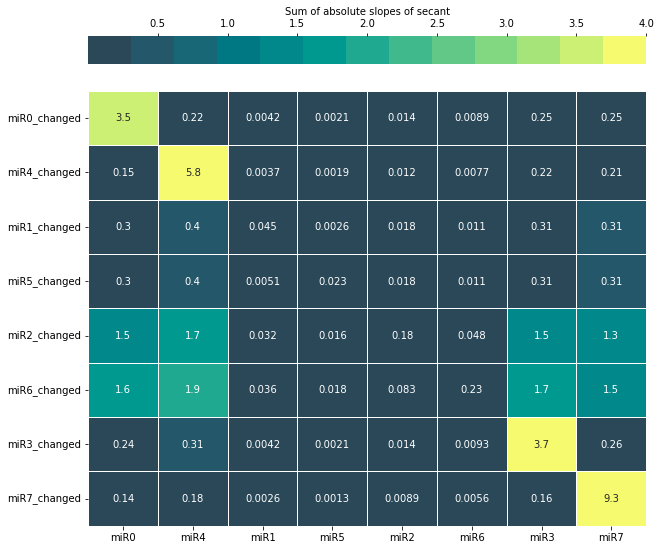

In [129]:
fig = plt.subplots(figsize = (10, 10))

ax = sns.heatmap(df_var,
                annot = True,
                linewidth =  1,
                cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Sum of absolute slopes of secant'},
                vmax = 4
                )

plt.savefig(destdir_figs + 'pvars_secant.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

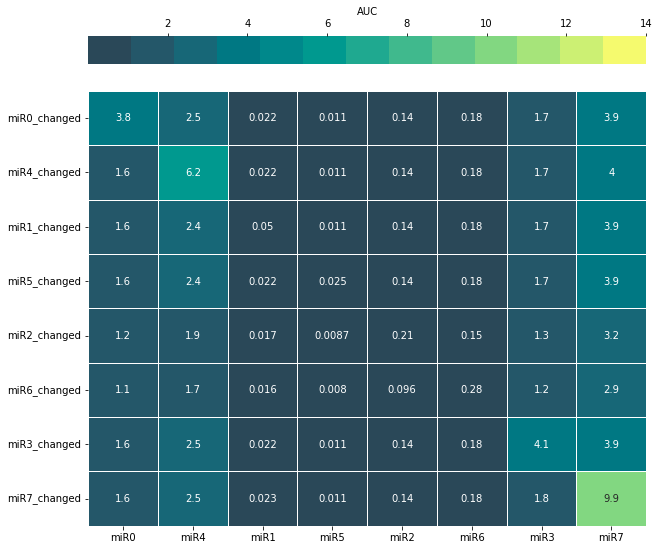

In [144]:
fig = plt.subplots(figsize = (10, 10))

ax = sns.heatmap(df_var_auc,
                annot = True,
                linewidth =  1,
                cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'AUC'},
                vmax = 14
                )

plt.savefig(destdir_figs + 'pvars_auc.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

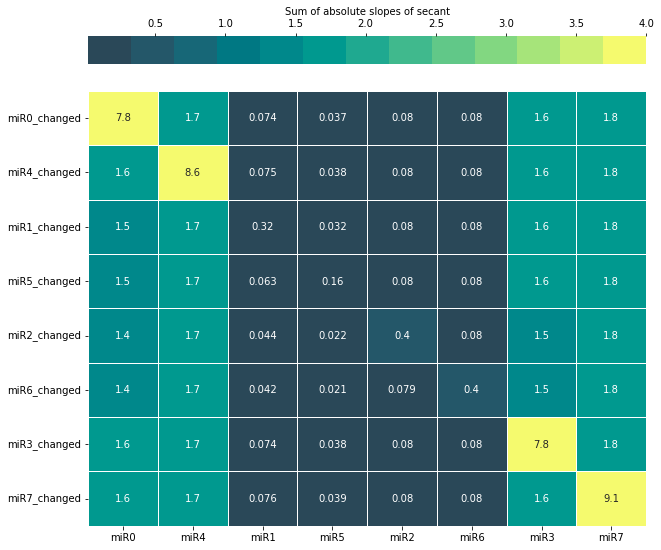

In [131]:
fig = plt.subplots(figsize = (10, 10))

ax = sns.heatmap(df_oe,
                annot = True,
                linewidth =  1,
                cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Sum of absolute slopes of secant'},
                vmax = 4
                )

plt.savefig(destdir_figs + 'oe_secant.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

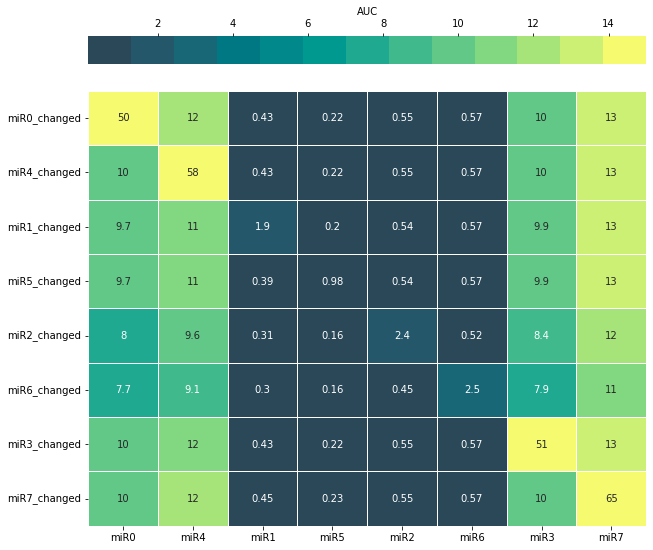

In [141]:
fig = plt.subplots(figsize = (10, 10))

ax = sns.heatmap(df_oe_auc,
                annot = True,
                linewidth =  1,
                cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'AUC'},
                vmax = 15
                )

plt.savefig(destdir_figs + 'oe_auc.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

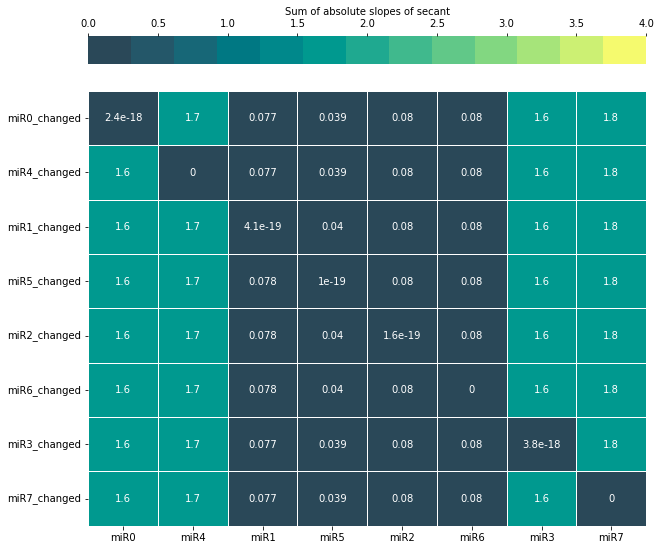

In [46]:
fig = plt.subplots(figsize = (10, 10))

ax = sns.heatmap(df_ko,
                annot = True,
                linewidth =  1,
                cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Sum of absolute slopes of secant'},
                vmax = 4
                )

plt.savefig(destdir_figs + 'ko_secant.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

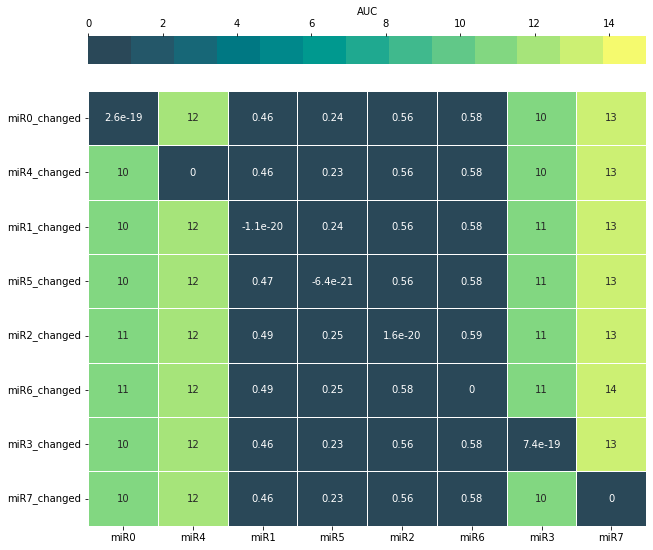

In [143]:
fig = plt.subplots(figsize = (10, 10))

ax = sns.heatmap(df_ko_auc,
                annot = True,
                linewidth =  1,
                cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'AUC'},
                vmax = 15
                )

plt.savefig(destdir_figs + 'ko_auc.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [48]:
#hacky surface differentiation for compressing surface plot to single number for heatmap
diffs = np.zeros((8,8))

for i in tqdm(range(8)):
    for j in range(8):
        diff = []
        for k in range(len(pvars)):
            y = ends['miR' + str(i) + '_changed'][j][k]
            dy = np.sum(abs(np.diff(y)/np.diff(dvars)))
            
            diff += [dy]
        
        diffs[i][j] = np.sum(abs(np.diff(np.array(diff))/np.diff(pvars)))

100%|██████████| 8/8 [00:00<00:00, 574.61it/s]


In [49]:
#for example plotting
diff = []
for k in range(len(pvars)):
    y = ends['miR0_changed'][0][k]
    dy = np.sum(abs(np.diff(y)/np.diff(dvars)))
            
    diff += [dy]

In [50]:
colnames = ['miR' + str(i) for i in range(8)]
index = list(ends.keys())
diff_df = pd.DataFrame(diffs, columns = colnames, index = index)
#reorder
diff_df = diff_df[col_order]
diff_df = diff_df.reindex(index_order)

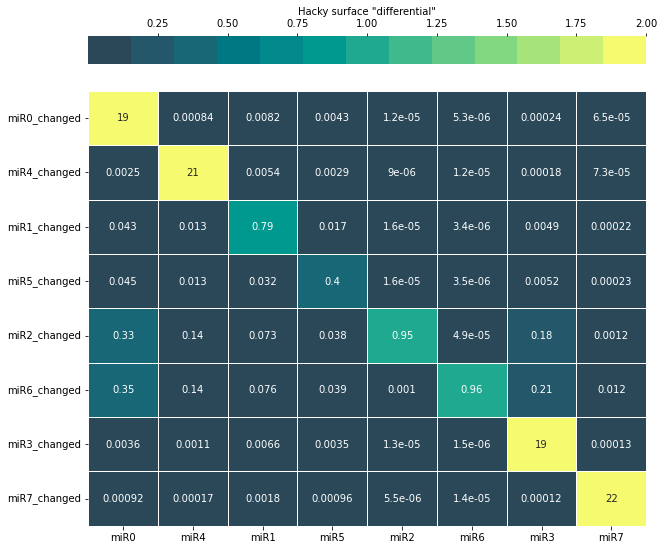

In [51]:
fig = plt.subplots(figsize = (10, 10))

ax = sns.heatmap(diff_df,
                annot = True,
                linewidth =  1,
                cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Hacky surface "differential"'},
                vmax = 2
                )

plt.savefig(destdir_figs + 'hacky_surface_differentiated.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [52]:
#hacky surface integration for compressing surface plot to single number for heatmap
aucs = np.zeros((8,8))

for i in tqdm(range(8)):
    for j in range(8):
        auc = []
        for k in range(len(pvars)):
            y = ends['miR' + str(i) + '_changed'][j][k]
            integrated = simpson(y = y,
                                 x = dvars,
                                 even = 'avg')
            
            auc += [integrated]
        
        aucs[i][j] = simpson(y = auc,
                                x = pvars,
                                even = 'avg')

  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\op20001\AppData\Local\Temp/ipykernel_8316/1498361904.py:9: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  integrated = simpson(y = y,
C:\Users\op20001\AppData\Local\Temp/ipykernel_8316/1498361904.py:15: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  aucs[i][j] = simpson(y = auc,
100%|██████████| 8/8 [00:00<00:00, 128.46it/s]


In [53]:
#for example plotting
auc = []
for k in range(len(pvars)):
    y = ends['miR0_changed'][0][k]
    integrated = simpson(y = y,
                         x = dvars,
                         even = 'avg')
            
    auc += [integrated]

C:\Users\op20001\AppData\Local\Temp/ipykernel_8316/461523723.py:5: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  integrated = simpson(y = y,


In [54]:
auc_df = pd.DataFrame(aucs, columns = colnames, index = index)
#reorder
auc_df = auc_df[col_order]
auc_df = auc_df.reindex(index_order)

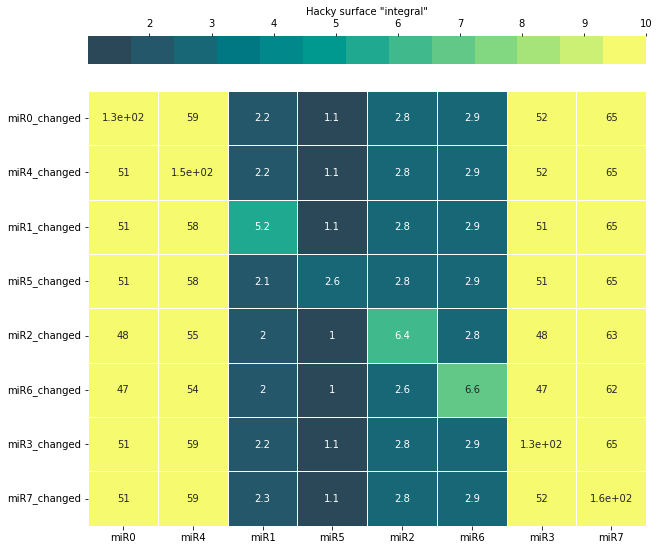

In [55]:
fig = plt.subplots(figsize = (10, 10))

ax = sns.heatmap(auc_df,
                annot = True,
                linewidth =  1,
                cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Hacky surface "integral"'},
                vmax = 10
                )

plt.savefig(destdir_figs + 'hacky_surface_integrated.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

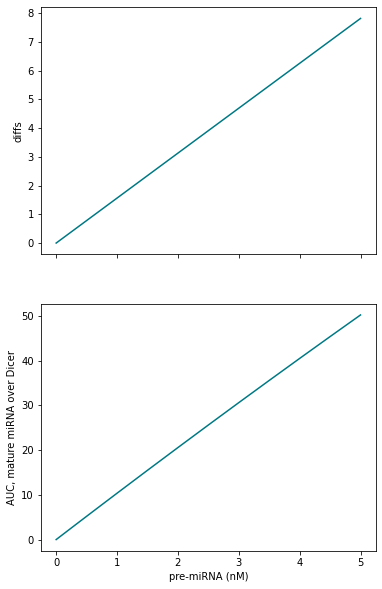

In [71]:
#example plot
fig, ax  = plt.subplots(2, sharex = True, figsize = (6, 10))

ax[0].plot(pvars,
           diff,
          color = custom_cmap_r[3])

ax[0].set_ylabel(r'diffs')

ax[1].plot(pvars,
           auc,
          color = custom_cmap_r[3])
ax[1].set_ylabel('AUC, mature miRNA over Dicer')
ax[1].set_xlabel(r'pre-miRNA (nM)')

plt.savefig(destdir_figs + 'example_plots_surface2.svg', dpi = 600, bbox_inches = 'tight')

plt.show()